# K-medoids and K-means Clustering for Image Compression
## Alfred Ka Chau Tang

In [1]:
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
import matplotlib.image as img

In [2]:
def flatten_pixels(image):
    """Flatten the matrix form of image pixels into an array form.
    
    The image pixels of dimensions (X, Y, Z) will be reduced to
    dimensions (X*Y, Z), where Z is the RGB channel. 

    Args:
        image (numpy.ndarray): image pixels of 3 dimensions, (X, Y, Z).
    
    Returns:
        numpy.ndarray: flatten image pixels of 2 dimensions, (X*Y, Z).
    
    Raises:
        TypeError: An error occurred when image is not an numpy array or
          it does not have 3 dimensions.
    """
    if type(image) != np.ndarray:
        raise TypeError(
            f"image has to be <class 'numpy.ndarray'>, not {type(image)}."
        )
    if len(image.shape) != 3:
        raise ValueError(
            f"image has to have 3 dimensions, not {len(image.shape)}."
        )
    
    return np.reshape(image, (image.shape[0]*image.shape[1], image.shape[2]))

In [3]:
def compress_k_medoids(pixels, K):
    """Compress images using K-medoids algorithm

    Image pixels will be replaced by their most similar cluster
    centroids' pixels, thereby reducing the size of the image.

    Args:
        pixels (numpy.ndarray): flatten image pixels of 2 dimensions,
          where the second dimension is the RGB channel only.
        K (int): the number of clusters.

    Returns:
        cluster_idx (numpy.ndarray): the indices indicate which cluster
          a pixel belongs to.
        centroids (numpy.ndarray): pixel values of the cluster centers.

    Raises:
        TypeError: an error occurred when pixels is not numpy array or
          K is not int.
        ValueError: an error occurred when K is not positive.
    """
    if type(pixels) != np.ndarray:
        raise TypeError(
            f"pixels has to be <class 'numpy.ndarray'>, not {type(pixels)}."
        )
    if type(K) != int:
        raise TypeError(
            f"K has to be <class 'int'>, not {type(K)}."
        )
    if K < 1:
        raise ValueError(
            "K must be positive"
        )
    
    # Initialize centroids randomly.
    centroids = pixels[np.random.randint(len(pixels), size=K)]
    # Calculate the distances between pixel points and all centroids to
    # obtain the distortion function, J.
    dists_with_K_centroids = spatial.distance.cdist(pixels, centroids,
                                                    metric="cityblock")
    J = np.sum(np.min(dists_with_K_centroids, axis=1))
    # Assign pixel points to their closest clusters.
    cluster_idx = np.argmin(dists_with_K_centroids, axis=1)
    
    new_centroids = np.zeros((K, pixels.shape[1]))
    new_J = 0
    pointer = 0
    
    while True:
        pointer += 1

        for k in range(K):
            pixel_idx = np.where(cluster_idx == k)[0]
            # If there is no pixel point or only the centroid itself,
            # then use a pixel point that is most different from this as
            # the substitute.
            if len(pixel_idx) <= 1:
                pixel_idx_with_largest_dist = np.argmax(
                    spatial.distance.cdist(pixels, [centroids[k]],
                                           metric='cityblock'))
                new_centroids[k] = pixels[pixel_idx_with_largest_dist]
            # For cases without empty cluster error, calculate the
            # distances between pixel points within the same cluster,
            # and then choose the one with the lowest distances with
            # others in the same cluster as the new centroid.
            else:
                k_pixels = pixels[pixel_idx]
                dists_within_k = np.sum(
                    spatial.distance.cdist(k_pixels, k_pixels,
                                           metric='cityblock'), axis=1)
                pixel_idx_with_lowest_dists = np.argmin(dists_within_k)
                new_centroids[k] = k_pixels[pixel_idx_with_lowest_dists]
        
        # Recalculate the distances between pixel points and all new
        # centroids to obtain the distortion function.
        dists_with_K_centroids = spatial.distance.cdist(pixels, new_centroids,
                                                        metric='cityblock')
        new_J = np.sum(np.min(dists_with_K_centroids, axis=1))
        
        # If the distortion function does not improve, stop.
        if new_J >= J or pointer == 100:
            break
        # If the distortion function improves, then update the centroids
        # as the new ones and the distortion function J as the new one.
        else:
            J = new_J
            centroids = new_centroids
            cluster_idx = np.argmin(dists_with_K_centroids, axis=1)
    
    return cluster_idx.astype(int), centroids.astype(np.uint8)

In [4]:
def compress_k_means(pixels, K):
    """Compress images using K-means algorithm

    Image pixels will be replaced by their most similar cluster
    centroids' pixels, thereby reducing the size of the image.

    Args:
        pixels (numpy.ndarray): flatten image pixels of 2 dimensions,
          where the second dimension is the RGB channel only.
        K (int): the number of clusters.

    Returns:
        cluster_idx (numpy.ndarray): the indices indicate which cluster
          a pixel belongs to.
        centroids (numpy.ndarray): pixel values of the cluster centers.

    Raises:
        TypeError: an error occurred when pixels is not numpy array or
          K is not int.
        ValueError: an error occurred when K is not positive.
    """
    if type(pixels) != np.ndarray:
        raise TypeError(
            f"pixels has to be <class 'numpy.ndarray'>, not {type(pixels)}."
        )
    if type(K) != int:
        raise TypeError(
            f"K has to be <class 'int'>, not {type(K)}."
        )
    if K < 1:
        raise ValueError(
            "K must be positive"
        )
    
    # Initialize centroids randomly.
    centroids = pixels[np.random.randint(len(pixels), size=K)]
    # Calculate the distances between pixel points and all centroids to
    # obtain the distortion function, J.
    dists_with_K_centroids = spatial.distance.cdist(pixels, centroids,
                                                    metric="cityblock")
    J = np.sum(np.min(dists_with_K_centroids, axis=1))
    # Assign pixel points to their closest clusters.
    cluster_idx = np.argmin(dists_with_K_centroids, axis=1)
    
    new_centroids = np.zeros((K, pixels.shape[1]))
    new_J = 0
    pointer = 0

    while new_J < J:
        pointer += 1

        for k in range(K):
            pixel_idx = np.where(cluster_idx == k)[0]
            # If there is no pixel point or only the centroid itself,
            # then use a pixel point that is most different from this as
            # the substitute.
            if len(pixel_idx) <= 1:
                pixel_idx_with_largest_dist = np.argmax(
                    spatial.distance.cdist(pixels, [centroids[k]], 
                                           metric="cityblock"))
                new_centroids[k] = pixels[pixel_idx_with_largest_dist]
            # For cases without empty cluster error, use the mean pixel
            # points calculated from pixel points in the same cluster as
            # the new centroid.
            else:
                k_pixels = pixels[pixel_idx]
                new_centroids[k] = np.mean(k_pixels, axis=0)
        
        # Recalculate the distances between pixel points and all new
        # centroids to obtain the distortion function.
        dists_with_K_centroids = spatial.distance.cdist(pixels, new_centroids, 
                                                        metric="cityblock")
        new_J = np.sum(np.min(dists_with_K_centroids, axis=1))
        
        # If the distortion function does not improve, stop.
        if new_J >= J or pointer == 100:
            break
        # If the distortion function improves, then update the centroids
        # as the new ones and the distortion function J as the new one.
        else:
            J = new_J
            centroids = new_centroids
            cluster_idx = np.argmin(dists_with_K_centroids, axis=1)

    
    return cluster_idx.astype(int), centroids.astype(np.uint8)

In [5]:
def reconstruct_image(cluster_idx, centroids, image):
    """Recontruct the compressed image
    
    Given the cluster_idx and centroids from compress_k_medoids or
    compress_k_means, reconstruct the compressed image according to its
    original's size.

    Args:
        cluster_idx (numpy.ndarray): the indices indicate which cluster
          a pixel belongs to; the first output from compress_k_medoids
          or compress_k_means.
        centroids (numpy.ndarray): pixel values of the cluster centers;
          the second output from compress_k_medoids or compress_k_means
        image (numpy.ndarray): image pixels of 3 dimensions, (X, Y, Z).
    
    Returns:
        numpy.ndarray: reconstructed image pixels of 3 dimensions,
        (X, Y, Z).
    
    Raises:
        TypeError: An error occurred when image is not an numpy array or
          it does not have 3 dimensions.
        ValueError: An error occurred when the third dimension of image
          is not RGB channel.
    """
    compressed_pixels = centroids[cluster_idx]
    compressed_image = np.reshape(compressed_pixels,
                                  (image.shape[0],
                                   image.shape[1],
                                   image.shape[2]))
    return compressed_image

In [6]:
img1 = img.imread('beach.bmp')
img2 = img.imread('football.bmp')
img3 = img.imread('my_picture.bmp')

pix1 = flatten_pixels(img1)
pix2 = flatten_pixels(img2)
pix3 = flatten_pixels(img3)

In [7]:
cluster_idx, centroids = compress_k_medoids(pix3, 32)
# cluster_idx, centroids = compress_k_means(pix3, 32)

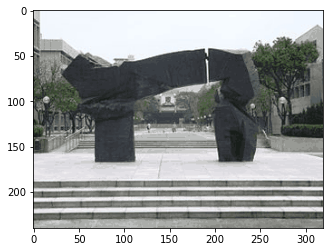

In [8]:
cp_img = reconstruct_image(cluster_idx, centroids, img3)
plt.imshow(cp_img)

In [9]:
# Save the compressed image as a bmp file.
# plt.imsave(str(32) + 'K_compressed_my_picture.bmp', cp_img)

## Performance Assessment

In [10]:
%timeit cluster_idx, centroids = compress_k_medoids(pix3, 32)

21.3 s ± 3.2 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit cluster_idx, centroids = compress_k_medoids(pix3, 512)

6.77 s ± 2.51 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%timeit cluster_idx, centroids = compress_k_medoids(pix3, 1024)

11.7 s ± 3.39 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%timeit cluster_idx, centroids = compress_k_medoids(pix3, 2048)

18 s ± 6.04 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%timeit cluster_idx, centroids = compress_k_medoids(pix3, 4096)

45.4 s ± 8.88 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
